In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from pls_theo import *
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
df = pd.read_csv('final_data_files/uncrowded_photometry.csv')

In [3]:
# things for plotting loop
funcs = [j_ab, j_c, h_ab, h_c, k_ab, k_c, t_ab, t_c, f_ab, f_c]
band_labels = ['j', 'h', 'k', '3', '4']
band_names = ['J', 'H', 'K_s', '[3.6]', '[4.5]']
plot_colors = [(0.718, 0, 0.718), (0.316, 0.316, 0.991),
               (0, 0.592, 0), (0.527, 0.527, 0), 
               (0.847, 0.057, 0.057)]
mag_offset = [8, 6, 4, 2, 0]
wavelength = [1.220, 1.630, 2.190, 3.550, 4.493]

In [4]:
# select only the rows with photometry for all bands
df1 = df[(np.isnan(df.mag_j) == 0) & (np.isnan(df.mag_h) == 0) & (np.isnan(df.mag_k) == 0) &
        (np.isnan(df.mag_3) == 0) & (np.isnan(df.mag_4) == 0)]

J ab 13.8392803591 0.0209206263834 c 13.8434030287 0.019628825591
H ab 13.7945756407 0.0283098869668 c 13.817051515 0.0267309405401
K_s ab 13.7901830276 0.0223536155413 c 13.8062789502 0.0220973288914
[3.6] ab 13.6941408623 0.0300720525208 c 13.7027601005 0.0484140159095
[4.5] ab 13.6657477875 0.045685131066 c 13.6857763415 0.0645751900636


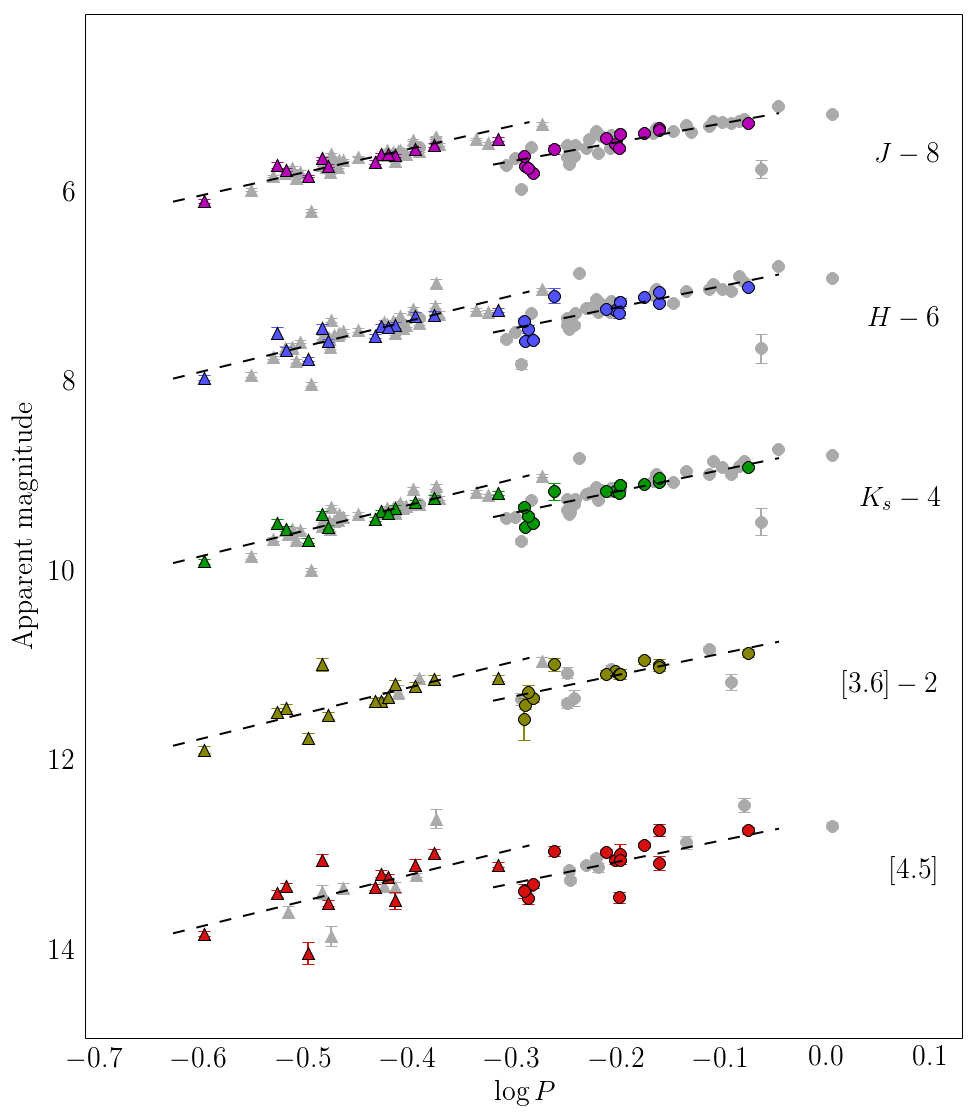

In [8]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(14.9, 4.1)
ax.set_xlim(-0.71, 0.13)

# separate full and cut sample dataframes into abs and cs
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]

dmod_prior = 14.
feh = -1.58404580153

per_ab = np.log10(df1_ab.per)
per_c = np.log10(df1_c.per)
xspace_ab = np.linspace(np.min(per_ab) - 0.03, np.max(per_ab) + 0.03, 100)
xspace_c = np.linspace(np.min(per_c) - 0.03, np.max(per_c) + 0.03, 100)

distance_df = {}
distance_df['wavelength'] = wavelength
distance_df['dist_ab'] = []
distance_df['dist_c'] = []
distance_df['err_ab'] = []
distance_df['err_c'] = []

for i in range(5):
    mag_ab = df1_ab['mag_' + band_labels[i]]
    merr_ab = df1_ab['merr_' + band_labels[i]]
    mag_c = df1_c['mag_' + band_labels[i]]
    merr_c = df1_c['merr_' + band_labels[i]]
    
    # do the fitting
    popt_ab, pcov_ab = curve_fit(funcs[i*2], per_ab, mag_ab, p0 = dmod_prior)
    popt_c, pcov_c = curve_fit(funcs[i*2 + 1], per_c, mag_c, p0 = dmod_prior)
    dist_ab, err_ab = popt_ab[0], np.sqrt(np.diag(pcov_ab))[0]
    dist_c, err_c = popt_c[0], np.sqrt(np.diag(pcov_c))[0]
    
    distance_df['dist_ab'].append(dist_ab)
    distance_df['err_ab'].append(err_ab)
    distance_df['dist_c'].append(dist_c)
    distance_df['err_c'].append(err_c)
    
    # fit lines for plotting + get residuals
    linfit_ab = funcs[i*2](xspace_ab, dist_ab)
    resid_ab = funcs[i*2](per_ab, dist_ab) - mag_ab
    linfit_c = funcs[i*2 + 1](xspace_c, dist_c)
    resid_c = funcs[i*2 + 1](per_c, dist_c) - mag_c
    
    df1_ab['resid_theo_' + band_labels[i]] = resid_ab
    df1_c['resid_theo_' + band_labels[i]] = resid_c

    print band_names[i], 'ab', dist_ab, err_ab, 'c', dist_c, err_c
    
    # plot full sample in grey
    plt.errorbar(np.log10(df_ab.per), df_ab['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_ab['merr_' + band_labels[i]], fmt='o', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)
    plt.errorbar(np.log10(df_c.per), df_c['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_c['merr_' + band_labels[i]], fmt='^', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)
    
    # plot cut sample in color
    plt.errorbar(per_ab, mag_ab - mag_offset[i], yerr=merr_ab, fmt='o', color=plot_colors[i])
    plt.errorbar(per_c, mag_c - mag_offset[i], yerr=merr_c, fmt='^', color=plot_colors[i])
    
    ppl.plot(xspace_ab, linfit_ab - mag_offset[i], 'k--', lw=1)
    ppl.plot(xspace_c, linfit_c - mag_offset[i], 'k--', lw=1)
    
    # add labels
    if mag_offset[i] == 0:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.2),
                 '${}$'.format(band_names[i]), ha='right')
    else:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.2),
                 '${} - {}$'.format(band_names[i], mag_offset[i]), ha='right')

ax.set_ylabel('Apparent magnitude')
ax.set_xlabel(r'$\log P$')
fig.tight_layout()
fig.savefig('final_plots/multiwavelength_PL_theo.pdf')

In [6]:
# incorporate residuals into full table and save

df1_withresid = pd.concat([df1_ab, df1_c])
df_withresid = df.merge(df1_withresid, how='outer', on=list(set(df.keys()) & set(df1_withresid.keys())))
df_withresid.sort('id', inplace=True)
df_withresid.to_csv('final_data_files/uncrowded_withresid.csv', index=False)

In [7]:
# make table of distances

weight_ab = len(per_ab)/float(len(df1))
weight_c = len(per_c)/float(len(df1))

distance_df['dist_mean'] = np.asarray(distance_df['dist_ab']) * weight_ab + \
                           np.asarray(distance_df['dist_c']) * weight_c
distance_df['err_mean'] = np.sqrt((np.asarray(distance_df['err_ab']) * weight_ab)**2 + \
                          (np.asarray(distance_df['err_c']) * weight_c)**2)
distance_df = pd.DataFrame.from_dict(distance_df)
distance_df = distance_df[['wavelength','dist_ab','err_ab','dist_c','err_c','dist_mean','err_mean']]
distance_df.to_csv('final_data_files/dist_phot_theo.csv', index=False)